In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
root_path = 'gdrive/My Drive/Datasets/'
train_path = 'gdrive/My Drive/Datasets/train'
test_path = 'gdrive/My Drive/Datasets/test'

In [3]:
import os
os.listdir(root_path)

['train', 'test']

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten 
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

In [5]:
IMAGE_SIZE = [224, 224]

In [6]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top = False)

58900480/58889256 [==============================] - 0s 0us/step


In [7]:
for layer in vgg.layers:
    layer.trainable = False

In [8]:
folders = glob(train_path + '/*')
folders

['gdrive/My Drive/Datasets/train/NORMAL',
 'gdrive/My Drive/Datasets/train/PNEUMONIA']

In [9]:
x = Flatten()(vgg.output)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

In [11]:
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
training_set = train_datagen.flow_from_directory(train_path, target_size=(224,224), batch_size=32, class_mode='categorical')

Found 2876 images belonging to 2 classes.


In [15]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
testing_set = test_datagen.flow_from_directory(test_path, target_size=(224,224), batch_size=32, class_mode='categorical')

Found 624 images belonging to 2 classes.


In [17]:
testing_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [18]:
result = model.fit_generator(
    training_set,
    validation_data=testing_set,
    epochs=5,
    steps_per_epoch=len(training_set),
    validation_steps=len(testing_set)
)
# val_accuracy: xx%
# accuracy: xx%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
90/90 [==============================] - 1843s 20s/step - loss: 0.3251 - accuracy: 0.8776 - val_loss: 0.2411 - val_accuracy: 0.9119
Epoch 2/5
90/90 [==============================] - 1831s 20s/step - loss: 0.1317 - accuracy: 0.9506 - val_loss: 0.2117 - val_accuracy: 0.9199
Epoch 3/5
90/90 [==============================] - 1821s 20s/step - loss: 0.1304 - accuracy: 0.9506 - val_loss: 0.2168 - val_accuracy: 0.9199
Epoch 4/5
90/90 [==============================] - 1831s 20s/step - loss: 0.0994 - accuracy: 0.9631 - val_loss: 0.2318 - val_accuracy: 0.9183
Epoch 5/5
90/90 [==============================] - 1817s 20s/step - loss: 0.0979 - accuracy: 0.9659 - val_loss: 0.2651 - val_accuracy: 0.9038


In [21]:
#getting the accuracy
model.evaluate_generator(training_set)
# output [loss, accuracy]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.08855130523443222, 0.9659249186515808]

In [22]:
#getting the validation accuracy
model.evaluate_generator(testing_set)
# output [val_loss, val_acc]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.26505163311958313, 0.9038461446762085]

[[167  67]
 [ 39 351]]
Testing Accuracy: 0.8301282051282052
Sensitivity: 0.8106796116504854
Specificity: 0.8397129186602871


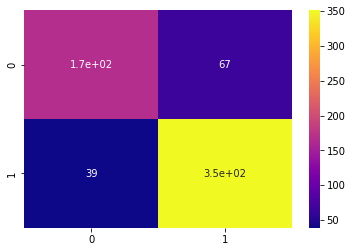

In [23]:
# Generate Confusion Matrix
import tensorflow as tf
y_actual = []
y_test = []

for i in os.listdir(test_path + '/NORMAL/'):
    img = image.load_img((test_path + '/NORMAL/')+i, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    p = model.predict(img)
    p = np.argmax(p,axis=1)
    y_test.append(p[0])
    y_actual.append(0)
    
for i in os.listdir(test_path + '/PNEUMONIA/'):
    img = image.load_img((test_path + '/PNEUMONIA/')+i, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    p = model.predict(img)
    p = np.argmax(p,axis=1)
    y_test.append(p[0])
    y_actual.append(1)
    
y_actual = np.array(y_actual)
y_test = np.array(y_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_actual, y_test)

import seaborn as sns
sns.heatmap(cm, cmap="plasma", annot=True)

model_TP = cm[0][0]
model_TN = cm[1][1]
model_FN = cm[1][0]
model_FP = cm[0][1]

print(cm)
print("Testing Accuracy:", (model_TP + model_TN) / (model_TP + model_TN + model_FP + model_FN))
print("Sensitivity:", (model_TP) / (model_TP + model_FN))
print("Specificity:", (model_TN) / (model_TN + model_FP))

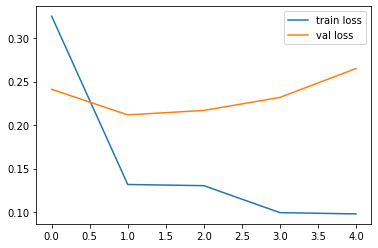

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

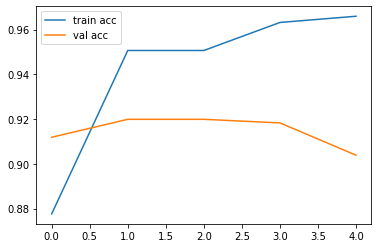

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(result.history['accuracy'], label='train acc')
plt.plot(result.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [26]:
import tensorflow as tf
from keras.models import load_model

model.save('model_vgg16.h5')